In [5]:
from qutip import *
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
class DicotomicProjector:
    def __init__(self, direction):
        sigma = [sigmax(),sigmay(),sigmaz()]
        self.dp_plus = 0.5*qeye(2)
        self.dp_minus = 0.5*qeye(2)
        for i in range(3):
            self.dp_plus += 0.5*direction[i]*sigma[i]
            self.dp_minus -= 0.5*direction[i]*sigma[i]
        self.dp = self.dp_plus - self.dp_minus #A = A^+ - A^-
        
class BellEnsemble:
    def __init__(self, alpha, p):
        #Generazione dello stato, se q=0 ho lo stato di Werner al variare di p, altrimenti ho lo stato composto
        self.alpha = alpha
        bell_a = np.cos(alpha)*tensor(basis(2,0),basis(2,0))+np.sin(alpha)*tensor(basis(2,1),basis(2,1))
        self.rho = p*bell_a*bell_a.dag() + (1 - p)*(tensor(qeye(2),qeye(2))/4)
        
class OptimizationRun:
    def __init__(self, state, x0=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]):
        self.state = state
        self.history = []
        self.x0 = x0
        self.run = scipy.optimize.minimize(self.func_free,self.x0,args=(self.state.rho),
                                           method='Nelder-Mead', callback=self.displayProgress,
                                           options={'disp':True, 'maxiter':4000, 'xatol':0.0001,
                                                    'fatol':0.0001, 'adaptive':True})
    def dirvector(self, angles):
        return [np.cos(angles[0])*np.sin(angles[1]),np.sin(angles[0])*np.sin(angles[1]),np.cos(angles[1])]
    
    def func_free(self, x, rho):
        #rho è la matrice densità fissata in input
        a0 = self.dirvector(x[0:2])
        a1 = self.dirvector(x[2:4])
        b0 = self.dirvector(x[4:6])
        b1 = self.dirvector(x[6:8])

        A0 = DicotomicProjector(a0)
        A1 = DicotomicProjector(a1)
        B0 = DicotomicProjector(b0)
        B1 = DicotomicProjector(b1)
        #.real serve perche' qutip da' valore complesso in output
        return ((tensor(A0.dp,B0.dp)*rho).tr() + (tensor(A0.dp,B1.dp)*rho).tr() + (tensor(A1.dp,B0.dp)*rho).tr() - (tensor(A1.dp,B1.dp)*rho).tr()).real
    
    def displayProgress(self, xk):
        #the callback function gets only the parameters vectors as an input, the state is a class parameter
        self.history.append(self.func_free(xk, self.state.rho))
    
    def run_plot(self, flag):
        fig = plt.figure()
        graph = fig.add_subplot(111)
        graph.plot(self.history, 'r-')
        graph.set_xlabel('Iterations')
        graph.set_ylabel('CHSH Value')
        graph.set_title(f"Parameters optimization with p={self.state.p} and q={self.state.q}")
        return fig
    

In [11]:
teststate = BellEnsemble(np.pi/4, 1)
testrun = OptimizationRun(teststate)
testrun.run

Optimization terminated successfully.
         Current function value: -2.828427
         Iterations: 438
         Function evaluations: 733


 final_simplex: (array([[-0.00382094, -0.43601417,  0.34756536,  1.15844843, -0.62031566,
         3.53309158, -0.23729019,  1.93647931],
       [-0.00382068, -0.43601601,  0.34758744,  1.15846301, -0.62040453,
         3.53309587, -0.23729099,  1.9364529 ],
       [-0.00382088, -0.43601315,  0.34758337,  1.15845944, -0.62033903,
         3.53307173, -0.23729713,  1.93648075],
       [-0.00382062, -0.43600363,  0.34758096,  1.15842329, -0.62039149,
         3.53305338, -0.23727393,  1.93645715],
       [-0.00382066, -0.4360085 ,  0.34756397,  1.15841803, -0.62033227,
         3.53308105, -0.23725461,  1.93646439],
       [-0.00382083, -0.43600911,  0.34758699,  1.15842659, -0.62031598,
         3.53310259, -0.23730559,  1.93645674],
       [-0.00382111, -0.43600589,  0.34757183,  1.1584348 , -0.62027167,
         3.53305551, -0.23727709,  1.93642724],
       [-0.00382065, -0.43600801,  0.34757723,  1.15841662, -0.62031555,
         3.53304817, -0.23731196,  1.93646618],
       [-0.0038

In [20]:
factors = []
violation = []
for factor in np.linspace(0,0.25,num=25):
        teststate = BellEnsemble(factor*np.pi,1)
        testrun = OptimizationRun(teststate)
        factors.append(factor*np.pi)
        violation.append(testrun.run.fun)

Optimization terminated successfully.
         Current function value: -2.000000
         Iterations: 502
         Function evaluations: 867
Optimization terminated successfully.
         Current function value: -2.004273
         Iterations: 1151
         Function evaluations: 1861
Optimization terminated successfully.
         Current function value: -2.016965
         Iterations: 959
         Function evaluations: 1537
Optimization terminated successfully.
         Current function value: -2.037705
         Iterations: 622
         Function evaluations: 1017
Optimization terminated successfully.
         Current function value: -2.065902
         Iterations: 890
         Function evaluations: 1445
Optimization terminated successfully.
         Current function value: -2.100784
         Iterations: 733
         Function evaluations: 1183
Optimization terminated successfully.
         Current function value: -2.141445
         Iterations: 875
         Function evaluations: 1385
Optimi

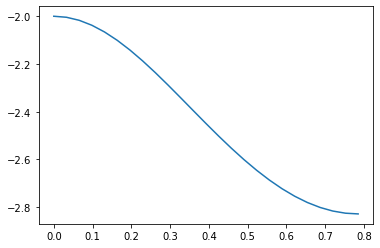

In [22]:
plt.figure()
plt.plot(factors,violation)
plt.show()

In [28]:
import pandas as pd
d = {'angle': factors,'chsh': violation}
pd.DataFrame(data=d)

angle      chsh
0   0.000000 -2.000000
1   0.032725 -2.004273
2   0.065450 -2.016965
3   0.098175 -2.037705
4   0.130900 -2.065902
5   0.163625 -2.100784
6   0.196350 -2.141445
7   0.229074 -2.186888
8   0.261799 -2.236068
9   0.294524 -2.287932
10  0.327249 -2.341444
11  0.359974 -2.395610
12  0.392699 -2.449490
13  0.425424 -2.502210
14  0.458149 -2.552967
15  0.490874 -2.601032
16  0.523599 -2.645751
17  0.556324 -2.686545
18  0.589049 -2.722905
19  0.621774 -2.754398
20  0.654498 -2.780657
21  0.687223 -2.801385
22  0.719948 -2.816354
23  0.752673 -2.825401
24  0.785398 -2.828427

In [31]:
factors[0::4], violation[0::4]

([0.0,
  0.1308996938995747,
  0.2617993877991494,
  0.39269908169872414,
  0.5235987755982988,
  0.6544984694978735,
  0.7853981633974483],
 [-1.999999999997695,
  -2.0659015446589994,
  -2.2360679774737333,
  -2.4494897426487756,
  -2.6457513109896427,
  -2.7806565425055796,
  -2.828427124032472])